In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from goatools.obo_parser import GODag
from goatools.associations import read_gaf
from goatools.associations import dnld_assc
from goatools.semantic import semantic_similarity
from goatools.semantic import TermCounts, get_info_content
from goatools.semantic import resnik_sim
from goatools.semantic import lin_sim
from goatools.semantic import deepest_common_ancestor

from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from adjustText import adjust_text
import textwrap

import proteomics_downstream_analysis as pda

import plotly.express as px
import plotly.io as pio


In [2]:
# dependencies
godag = GODag("go-basic.obo")

# read annotationsfile
associations = read_gaf("goa_human.gaf")

# First get the counts of each GO term.
termcounts = TermCounts(godag, associations)

go-basic.obo: fmt(1.2) rel(2023-03-06) 46,579 Terms
HMS:0:00:08.795923 630,196 annotations READ: goa_human.gaf 
17543 IDs in loaded association branch, BP


In [3]:
# read files
filepaths = ['/Users/tungvuduc/Desktop/PhD/projects/PPMI-urine/urine_analysis/pv_data.csv',
             '/Users/tungvuduc/Desktop/PhD/projects/PPMI-urine/urine_analysis/qv_data.csv', 
             '/Users/tungvuduc/Desktop/PhD/projects/PPMI-urine/urine_analysis/fc_data.csv']

# read files
data = [pd.read_csv(filepath).iloc[:,1:] for filepath in filepaths]
pv_data, qv_data, fc_data = data

In [4]:
# perform enrichment analysis
comparison = 'Control/Prodromal'
cond1 = fc_data[comparison] < 0
cond2 = qv_data[comparison] < 0.05
genes = fc_data[cond1 & cond2]['Genes'].tolist()

enr = pda.EnrichmentAnalysis('go-basic.obo', 'goa_human.gaf')
go_datasets = enr.array_enrichment_analysis(genes, 'human', False)

go-basic.obo: fmt(1.2) rel(2023-03-06) 46,579 Terms
HMS:0:00:10.553614 630,196 annotations READ: goa_human.gaf 
17543 IDs in loaded association branch, BP


In [5]:
# functions
def filter_go_data(go_data, godag):
    return go_data[go_data['GO term ID'].isin(godag.keys())]

def calculate_semantic_similarity_between_go_terms(go_data, godag,termcounts):

    go_data = filter_go_data(go_data, godag)
    go_termids = go_data['GO term ID'].tolist()

    sem_sims = np.zeros((len(go_termids), len(go_termids)))
    for ax1, i in enumerate(go_termids):
        for ax2, j in enumerate(go_termids):
            sem_sims[ax1, ax2] = lin_sim(i, j, godag, termcounts)

    return sem_sims

def perform_mds(sem_sims):
    
    np.random.seed(42)
    embedding = MDS(n_components=2,
                    normalized_stress='auto', 
                    dissimilarity='euclidean')

    X_transformed = embedding.fit_transform(np.nan_to_num(sem_sims, 0))

    return X_transformed

def cluster_mds_scores(x, n_clusters=25):

    knn = KMeans(n_clusters=n_clusters, 
                n_init=10,
                random_state=42)
    output = knn.fit(x)

    labels = output.labels_
    hue = [str(i) for i in labels] 

    return labels, hue

def calculate_deepest_common_ancestor(go_data, labels, godag, ):
    
    deepest_common_ancestors = []
    for i in range(len(np.unique(labels))):
        id_cluster = go_data[labels == i]['GO term ID'].tolist()
        go_root = deepest_common_ancestor(id_cluster, godag)
        dca = godag[go_root].name
        deepest_common_ancestors.append(dca)
    return deepest_common_ancestors

def calculate_center(x, labels):

    center = []
    for i in range(len(np.unique(labels))):
        x_cluster = x[labels == i]
        center.append(np.mean(x_cluster, axis=0))
    return center

def customwrap(s, width=15):
    return "<br>".join(textwrap.wrap(s,width=width))

def plot_enrichment_mds(x, hue, names, centers, pvalues, title=None,
                        figsize=(8,8), savefig=True,
                        dir='enrichment_mds.pdf'):

    plt.figure(figsize=figsize)
    sns.scatterplot(x=x[:,0],
                    y=x[:,1], 
                    hue=hue,
                    size=pvalues,
                    sizes=(50, 200),
                    )
    plt.xlabel('MDS1')
    plt.ylabel('MDS2')
    plt.legend().set_visible(False)
    texts = [plt.text(center[0], center[1], names[idx], ha='center', va='center', fontsize=9)
             for idx, center in enumerate(centers)]    
    adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'black'))

    if savefig == True:
        plt.savefig(dir, bbox_inches='tight')
    plt.title(title)
    plt.show()

# def interactive_plotting_data
def create_plotly_data(x, hue, go_data, godag):
    
    go_data = filter_go_data(go_data, godag)
    data = pd.DataFrame(x, columns=['MDS1', 'MDS2'])
    data['hue'] = hue
    data['Term'] = go_data['Term'].tolist()
    data['Adjusted P-value'] = go_data['Adjusted P-value'].tolist()

    return data

# plot interactive enrichment_plot

def plot_interactive_enrichment_mds(data, labels, centers, names,
                                    title=None, figsize=(700, 700),
                                    save=False, dir='int_enrichment.html'):
    fig = px.scatter(data,
                    x='MDS1',
                    y='MDS2',
                    color='hue',
                    size='Adjusted P-value',
                    hover_data={'Term': True,
                                'MDS1': False, # hide
                                'MDS2': False, # hide
                                'hue':False, # hide
                                'Adjusted P-value':False}, # hide
                    color_discrete_sequence=px.colors.qualitative.Vivid,
                    title=title)

    fig.update_layout(template='simple_white',
                            height=figsize[0],
                            width=figsize[1],
                            showlegend=False)

    for i in range(len(np.unique(labels))):
        fig.add_annotation(x=centers[i][0],
                            y=centers[i][1],
                            text=list(map(customwrap, names))[i],
                            showarrow=True,
                            arrowhead=0)

    if save == True:
        # Save the plot as an HTML file
        pio.write_html(fig, f'{dir}')

    fig.show()


def prepare_data_for_enrichment_mds(go_data, godag, termcounts):

    # filter the go_data to only contain go terms in the godag
    go_data = filter_go_data(go_data, godag)

    # calculate the semantic similarity between given go terms
    sem_sims = calculate_semantic_similarity_between_go_terms(go_data, godag, termcounts)

    # perform mds on the semantic similarity matrix
    X_transformed = perform_mds(sem_sims)

    # cluster the mds scores
    labels, hue = cluster_mds_scores(X_transformed)

    # calculate the center of each cluster
    centers = calculate_center(X_transformed, labels)

    # calculate the deepest common ancestor of each cluster
    dca = calculate_deepest_common_ancestor(go_data, labels, godag)

    # get the names of the go terms and the pvalues
    names = [textwrap.fill(i, 15) for i in dca]
    pvalues = go_data['Adjusted P-value'].tolist()

    return X_transformed, hue, labels, names, centers, pvalues



In [ ]:
X_transformed, hue, labels, names, centers, pvalues = prepare_data_for_enrichment_mds(go_datasets[0], godag, termcounts)
plot_enrichment_mds(X_transformed, hue, names, centers, pvalues)

In [7]:
data = create_plotly_data(X_transformed, hue, go_datasets[0], godag)
plot_interactive_enrichment_mds(data, labels, centers, names)

/Users/tungvuduc/opt/anaconda3/envs/DiannOOP/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


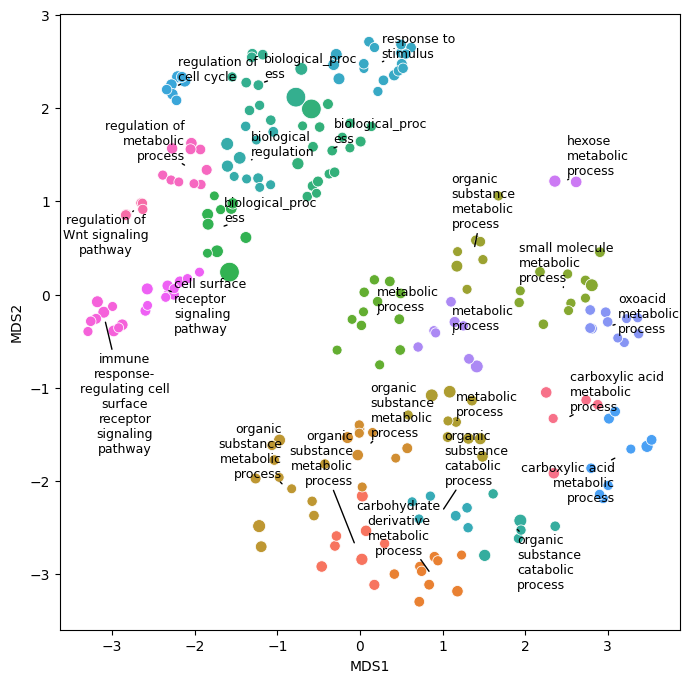

In [5]:
#
X_transformed, hue, labels, names, centers, pvalues = enr.prepare_data_for_enrichment_mds(go_datasets[0], godag, termcounts)
enr.plot_enrichment_mds(X_transformed, hue, names, centers, pvalues)
data = enr.create_plotly_data(X_transformed, hue, go_datasets[0], godag)
enr.plot_interactive_enrichment_mds(data, labels, centers, names)